# Clearing Working Directory

# Importing Important Imports

In [2]:
import os
import json
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.model_selection import train_test_split

# Loading Dataset

In [3]:
awe_directory = '/kaggle/input/finalyearproject/awe'

if not os.path.exists(awe_directory):
    print(f"The specified directory does not exist: {awe_directory}")
else:
    json_paths = []
    
    for folder in os.listdir(awe_directory):
        folder_path = os.path.join(awe_directory, folder)
        if os.path.isdir(folder_path):
            for json_file in os.listdir(folder_path):
                if json_file.endswith('.json'):
                    json_path = os.path.join(folder_path, json_file)
                    json_paths.append(json_path)

    if json_paths:
        print(f"Found {len(json_paths)} JSON files.")
        images = []
        ethnicities = []
        genders = []

        for json_path in json_paths:
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)

            for key, value in data['data'].items():
                file_path = os.path.join(os.path.dirname(json_path), value['file'])
                image = Image.open(file_path)
                image = image.convert('RGB')
                image = image.resize((128, 128))  
                image_array = np.array(image) / 255.0 
                images.append(image_array)

                ethnicity = data['ethnicity']
                if ethnicity == 99:
                    ethnicity = 9
                    
                ethnicities.append(ethnicity)

                gender = data['gender']
                genders.append(gender)

        images = np.array(images)
        ethnicities = np.array(ethnicities)
        genders = np.array(genders)

Found 100 JSON files.


## Finding the labels which are missing for ethnicity

In [4]:
arr = [0]*10

for folder in sorted(os.listdir(awe_directory)):
    folder_path = os.path.join(awe_directory, folder)
  
    if os.path.isdir(folder_path):
        file_path = os.path.join(folder_path, f'annotations.json') 
        with open(file_path, 'r') as file:
            data = json.load(file)

            val = data['ethnicity']
            if val == 99:
                val = 9
            arr[val] += 1
            
print(arr)

[0, 61, 18, 3, 11, 3, 3, 0, 0, 1]


In [5]:
""" Missing values are - 7 and 8 as evident from the array above, hence we have 7 classes in total, 
not 9 (Also 9 can be removed as it was 99 not 9 so we need to check, it maybe 6 classes only) """ 

' Missing values are - 7 and 8 as evident from the array above, hence we have 7 classes in total, \nnot 9 (Also 9 can be removed as it was 99 not 9 so we need to check, it maybe 6 classes only) '

# One-Hot Encoding the labels

In [6]:
num_ethnicity_classes = 7

ethnicity_labels_onehot = np.zeros((len(ethnicities), num_ethnicity_classes))
for i, ethnicity in enumerate(ethnicities):
    if ethnicity in [1, 2, 3, 4, 5, 6, 9]:
        ethnicity_index = ethnicity - 1 if ethnicity in [1, 2, 3, 4, 5, 6] else 6 
        ethnicity_labels_onehot[i, ethnicity_index] = 1

gender_encoder = {"m": 0, "f": 1}
gender_labels_encoded = np.array([gender_encoder[gender] for gender in genders])

X_train, X_test, Y_ethnicity_train, Y_ethnicity_test, Y_gender_train, Y_gender_test = train_test_split(
    images, ethnicity_labels_onehot, gender_labels_encoded, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape)
print(Y_ethnicity_train.shape)
print(Y_gender_train.shape)

(800, 128, 128, 3)
(800, 7)
(800,)


In [8]:
print(len(X_train), len(X_test))
print(len(Y_ethnicity_train), len(Y_ethnicity_test))
print(len(Y_gender_train), len(Y_gender_test))

800 200
800 200
800 200


# Model Building

In [265]:
def make_model_1(input_shape=(128, 128, 3), num_ethnicity_classes=7):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation= 'relu')(x)
    x = layers.Dense(64, activation= 'relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation= 'relu')(x)

    ethnicity_output = layers.Dense(num_ethnicity_classes, activation='softmax', name='ethnicity_output')(x)

    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

    model = keras.Model(inputs=input_layer, outputs=[ethnicity_output, gender_output], name = 'final_model')

    return model

In [67]:
def make_model_2(input_shape=(128, 128, 3), num_ethnicity_classes=7):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.GlobalAveragePooling2D()(x)  
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    ethnicity_output = layers.Dense(num_ethnicity_classes, activation='softmax', name='ethnicity_output')(x)
    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)
    model = keras.Model(inputs=input_layer, outputs=[ethnicity_output, gender_output], name='final_model_no_fc')

    return model


In [91]:
def make_model_3(input_shape=(128, 128, 3), num_ethnicity_classes=7):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation= 'relu')(x)
    x = layers.Dense(64, activation= 'relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation= 'relu')(x)

    ethnicity_output = layers.Dense(num_ethnicity_classes, activation='softmax', name='ethnicity_output')(x)

    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

    model = keras.Model(inputs=input_layer, outputs=[ethnicity_output, gender_output], name = 'final_model')

    return model

In [9]:
def make_model_4(input_shape=(128, 128, 3), num_ethnicity_classes=7):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation= 'relu')(x)
    x = layers.Dense(64, activation= 'relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation= 'relu')(x)

    ethnicity_output = layers.Dense(num_ethnicity_classes, activation='softmax', name='ethnicity_output')(x)

    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

    model = keras.Model(inputs=input_layer, outputs=[ethnicity_output, gender_output], name = 'final_model')

    return model

In [164]:
def make_model_5(input_shape=(128, 128, 3), num_ethnicity_classes=7):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation= 'relu')(x)
    x = layers.Dense(64, activation= 'relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation= 'relu')(x)

    ethnicity_output = layers.Dense(num_ethnicity_classes, activation='softmax', name='ethnicity_output')(x)

    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

    model = keras.Model(inputs=input_layer, outputs=[ethnicity_output, gender_output], name = 'final_model')

    return model

In [187]:
def make_model_6(input_shape=(128, 128, 3), num_ethnicity_classes=7):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation= 'relu')(x)
    x = layers.Dense(64, activation= 'relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation= 'relu')(x)

    ethnicity_output = layers.Dense(num_ethnicity_classes, activation='softmax', name='ethnicity_output')(x)

    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

    model = keras.Model(inputs=input_layer, outputs=[ethnicity_output, gender_output], name = 'final_model')

    return model

In [10]:
model = make_model_4()
model.summary()

Model: "final_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0

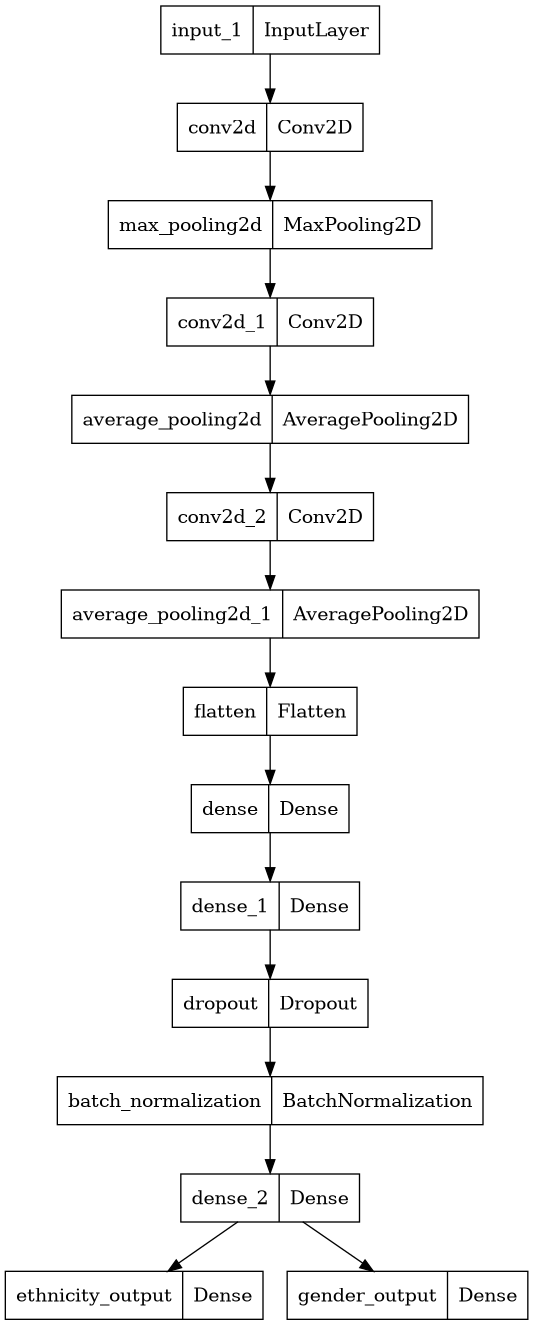

In [11]:
tf.keras.utils.plot_model(model, "final_model.png")

In [12]:
checkpoint_path = 'Epoch:{epoch:002d}-Accuracy:{val_ethnicity_output_accuracy:.2f}.h5'
checkpoint_dir = os.path.dirname('\kaggle\working')

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

csv_logger =tf.keras.callbacks.CSVLogger('/kaggle/working/log.csv', separator=",", append=True)

# Model Training

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss={'ethnicity_output': 'categorical_crossentropy', 'gender_output': 'binary_crossentropy'},
              metrics={'ethnicity_output': 'accuracy', 'gender_output': 'accuracy'})

In [14]:
history = model.fit(
    X_train,
    {'ethnicity_output': Y_ethnicity_train, 'gender_output': Y_gender_train},
    validation_data=(X_test, {'ethnicity_output': Y_ethnicity_test, 'gender_output': Y_gender_test}),
    epochs=100,  
    batch_size=32,  
    verbose=1,
    callbacks=[callback,csv_logger]
)

Epoch 1/100
25/25 [==============================] - 6s 36ms/step - loss: 2.5667 - ethnicity_output_loss: 1.7636 - gender_output_loss: 0.8031 - ethnicity_output_accuracy: 0.3775 - gender_output_accuracy: 0.3913 - val_loss: 4.0445 - val_ethnicity_output_loss: 1.5942 - val_gender_output_loss: 2.4503 - val_ethnicity_output_accuracy: 0.5800 - val_gender_output_accuracy: 0.0600
Epoch 2/100
25/25 [==============================] - 0s 15ms/step - loss: 1.9614 - ethnicity_output_loss: 1.4303 - gender_output_loss: 0.5311 - ethnicity_output_accuracy: 0.5838 - gender_output_accuracy: 0.7812 - val_loss: 2.7267 - val_ethnicity_output_loss: 2.4795 - val_gender_output_loss: 0.2472 - val_ethnicity_output_accuracy: 0.5850 - val_gender_output_accuracy: 0.9400
Epoch 3/100
25/25 [==============================] - 0s 15ms/step - loss: 1.6977 - ethnicity_output_loss: 1.2934 - gender_output_loss: 0.4043 - ethnicity_output_accuracy: 0.6062 - gender_output_accuracy: 0.8963 - val_loss: 2.6724 - val_ethnicity_ou

In [15]:
model.save('model_4_new.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
model.save_weights('model_4_weights_new.h5')

In [17]:
from keras.models import load_model
model_path = '/kaggle/working/model_4_new.h5'
loaded_model = load_model(model_path)

In [18]:
print(loaded_model)

# Tuner Imports

In [19]:
# from keras.models import load_model
from keras_tuner import RandomSearch
import keras

from keras import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

import numpy as np
import keras_tuner as kt
from keras_tuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/tmp/ipykernel_47/3599584203.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [20]:
def build_model_with_loaded_model(hp, loaded_model):
    # Clone the model
    model = keras.models.clone_model(loaded_model)
    
    # Choose the optimizer and instantiate it with the learning rate
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop', 'adadelta', 'nadam'])
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=0.05)
    elif optimizer_choice == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=0.05)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=0.05)
    elif optimizer_choice == 'adadelta':
        optimizer = keras.optimizers.Adadelta(learning_rate=0.05)
    elif optimizer_choice == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=0.05)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=hp.Choice('loss_function', values=['mean_squared_error', 'categorical_crossentropy', 'kl_divergence']),
        metrics=['accuracy']
    )
    
    return model

In [23]:
# Set up the tuner
tuner = RandomSearch(
    lambda hp: build_model_with_loaded_model(hp, loaded_model=loaded_model),
    objective = kt.Objective("val_ethnicity_output_loss", direction="min"),
    max_trials=5,
    executions_per_trial=5,
    directory='/kaggle/working/',
    project_name='Conference Tuner Data 5'
)

In [34]:
checkpoint_filepath = 'model.{val_ethnicity_output_loss:.2f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_ethnicity_output_loss',
    mode = 'min',
    save_best_only = True
)

In [24]:
tuner.search(X_train, {'ethnicity_output': Y_ethnicity_train, 'gender_output': Y_gender_train},
    validation_data=(X_test, {'ethnicity_output': Y_ethnicity_test, 'gender_output': Y_gender_test}),
             epochs=5,
#              callbacks = [model_checkpoint_callback]
            )

Trial 5 Complete [00h 00m 25s]
val_ethnicity_output_loss: 4.834120202064514

Best val_ethnicity_output_loss So Far: 0.09250591397285461
Total elapsed time: 00h 02m 47s


In [26]:
# After running the tuner search
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save('tuner_best_model.h5')

# Load the best model to update your current model
from keras.models import load_model

updated_model = load_model('/kaggle/working/tuner_best_model.h5')

In [42]:
csv_logger =tf.keras.callbacks.CSVLogger('/kaggle/working/tuned_log.csv', separator=",", append=True)

In [43]:
history2 = updated_model.fit(
    X_train,
    {'ethnicity_output': Y_ethnicity_train, 'gender_output': Y_gender_train},
    validation_data=(X_test, {'ethnicity_output': Y_ethnicity_test, 'gender_output': Y_gender_test}),
    epochs=100,  
    batch_size=32,  
    verbose=1,
    callbacks=[callback,csv_logger]
)

Epoch 1/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1700 - ethnicity_output_loss: 0.0819 - gender_output_loss: 0.0881 - ethnicity_output_accuracy: 0.6162 - gender_output_accuracy: 0.9025 - val_loss: 0.1489 - val_ethnicity_output_loss: 0.0905 - val_gender_output_loss: 0.0584 - val_ethnicity_output_accuracy: 0.5850 - val_gender_output_accuracy: 0.9400
Epoch 2/100
25/25 [==============================] - 0s 15ms/step - loss: 0.1705 - ethnicity_output_loss: 0.0822 - gender_output_loss: 0.0883 - ethnicity_output_accuracy: 0.6162 - gender_output_accuracy: 0.9025 - val_loss: 0.1480 - val_ethnicity_output_loss: 0.0905 - val_gender_output_loss: 0.0575 - val_ethnicity_output_accuracy: 0.5850 - val_gender_output_accuracy: 0.9400
Epoch 3/100
25/25 [==============================] - 0s 15ms/step - loss: 0.1703 - ethnicity_output_loss: 0.0822 - gender_output_loss: 0.0881 - ethnicity_output_accuracy: 0.6162 - gender_output_accuracy: 0.9025 - val_loss: 0.1477 - val_ethnicity_ou

In [37]:
# loaded_model.summary()

Model: "final_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0

In [38]:
# loaded_model.save_weights('T_loaded_model_weights.h5')

In [39]:
# model.save_weights('T_model_weights.h5')

In [48]:
import zipfile
import os

folder_path = '/kaggle/working/Conference Tuner Data 4'  
zip_path = '/kaggle/working/my_folder.zip'  

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through directory
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Create a complete filepath of file in directory
                filepath = os.path.join(root, file)
                # Add file to zip
                zipf.write(filepath, os.path.relpath(filepath, os.path.join(folder_path, '..')))

# Now call the function to zip the folder
zip_folder(folder_path, zip_path)

In [153]:
# Results for all 6 models.

# Model 1
# Trial 5 Complete [00h 00m 25s]
# val_ethnicity_output_loss: 1.3243904113769531
# Best val_ethnicity_output_loss So Far: 0.10914891362190246
# Total elapsed time: 00h 02m 40s

# Model 2
# Trial 5 Complete [00h 00m 25s]
# val_ethnicity_output_loss: 93.599560546875
# Best val_ethnicity_output_loss So Far: 0.11051182150840759
# Total elapsed time: 00h 02m 10s

# Model 3
# Trial 5 Complete [00h 00m 33s]
# val_ethnicity_output_loss: 1.7698161363601685
# Best val_ethnicity_output_loss So Far: 0.09043360501527786
# Total elapsed time: 00h 02m 49s

# Model 4
# Trial 5 Complete [00h 00m 30s]
# val_ethnicity_output_loss: 0.12125619500875473
# Best val_ethnicity_output_loss So Far: 0.08954745531082153
# Total elapsed time: 00h 02m 33s

# Model 5
# Trial 5 Complete [00h 00m 23s]
# val_ethnicity_output_loss: 0.10889851599931717
# Best val_ethnicity_output_loss So Far: 0.10889851599931717
# Total elapsed time: 00h 02m 19s

# Model 6
# Trial 5 Complete [00h 00m 26s]
# val_ethnicity_output_loss: 1.3069764614105224
# Best val_ethnicity_output_loss So Far: 0.09364216178655624
# Total elapsed time: 00h 02m 33s

In [347]:
#Model 4 Trial One
# Trial 5 Complete [00h 00m 40s]
# val_ethnicity_output_loss: 0.09178571552038192
# Best val_ethnicity_output_loss So Far: 0.0915200099349022
# Total elapsed time: 00h 03m 00s


# Model 4 Trial Two
# Trial 5 Complete [00h 00m 32s]
# val_ethnicity_output_loss: 0.0924727439880371
# Best val_ethnicity_output_loss So Far: 0.09153493791818619
# Total elapsed time: 00h 02m 57s


# Model 4 Trial Three
# Trial 5 Complete [00h 00m 28s]
# val_ethnicity_output_loss: 1.3171375513076782
# Best val_ethnicity_output_loss So Far: 0.09891759008169174
# Total elapsed time: 00h 02m 47s

# Model 4 Trial Four
# Trial 5 Complete [00h 00m 41s]
# val_ethnicity_output_loss: 1426.8175170898437
# Best val_ethnicity_output_loss So Far: 0.09539459198713303
# Total elapsed time: 00h 02m 53s

# Results 

In [201]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Accuracy and Loss Graphs

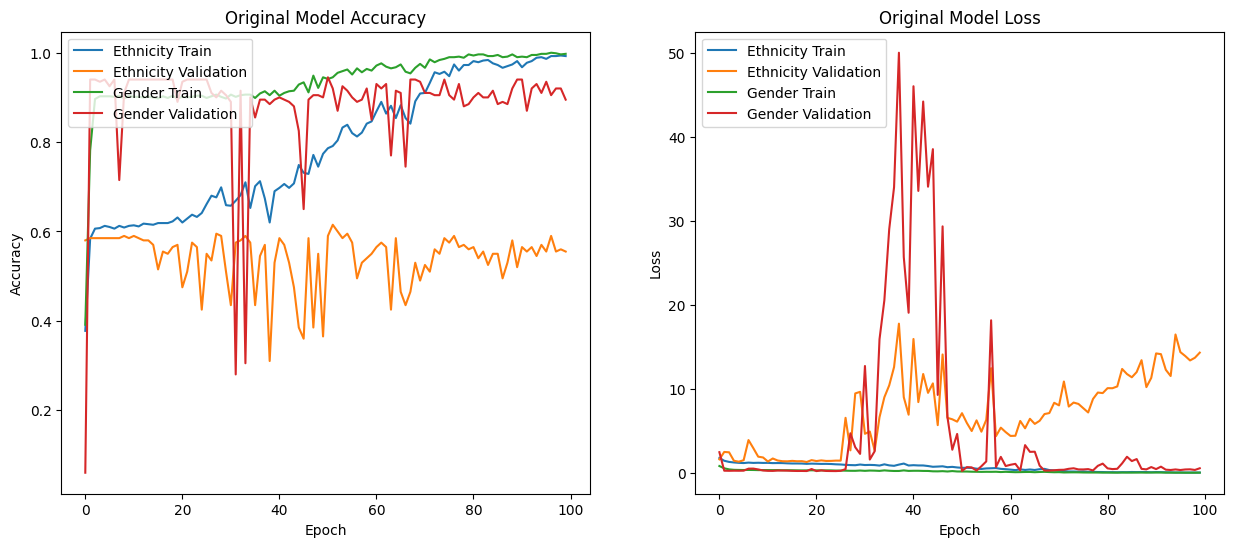

In [40]:
plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['ethnicity_output_accuracy'])
plt.plot(history.history['val_ethnicity_output_accuracy'])
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Original Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Ethnicity Train', 'Ethnicity Validation', 'Gender Train', 'Gender Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['ethnicity_output_loss'])
plt.plot(history.history['val_ethnicity_output_loss'])
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Original Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Ethnicity Train', 'Ethnicity Validation', 'Gender Train', 'Gender Validation'], loc='upper left')
plt.show()


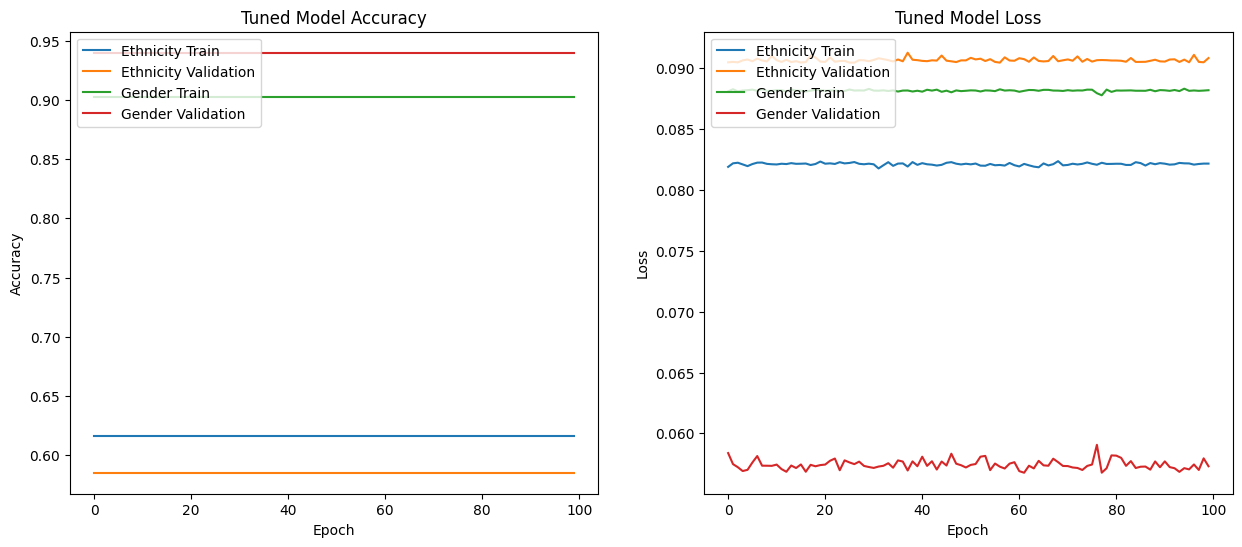

In [44]:
plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
plt.plot(history2.history['ethnicity_output_accuracy'])
plt.plot(history2.history['val_ethnicity_output_accuracy'])
plt.plot(history2.history['gender_output_accuracy'])
plt.plot(history2.history['val_gender_output_accuracy'])
plt.title('Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Ethnicity Train', 'Ethnicity Validation', 'Gender Train', 'Gender Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history2.history['ethnicity_output_loss'])
plt.plot(history2.history['val_ethnicity_output_loss'])
plt.plot(history2.history['gender_output_loss'])
plt.plot(history2.history['val_gender_output_loss'])
plt.title('Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Ethnicity Train', 'Ethnicity Validation', 'Gender Train', 'Gender Validation'], loc='upper left')
plt.show()

## Classification Report

In [35]:
ethnicity_pred, gender_pred = model.predict(X_test)
ethnicity_report = classification_report(Y_ethnicity_test.argmax(axis=1), ethnicity_pred.argmax(axis=1))
gender_report = classification_report(Y_gender_test, (gender_pred > 0.5).astype(int))


print("Ethnicity Classification Report:\n", ethnicity_report)
print("\n\n\n")
print("Gender Classification Report:\n", gender_report)

7/7 [==============================] - 0s 4ms/step
Ethnicity Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70       117
           1       0.39      0.50      0.44        34
           2       0.00      0.00      0.00         7
           3       0.40      0.40      0.40        25
           4       0.25      0.33      0.29         3
           5       0.14      0.10      0.12        10
           6       0.25      0.25      0.25         4

    accuracy                           0.56       200
   macro avg       0.31      0.33      0.31       200
weighted avg       0.55      0.56      0.55       200





Gender Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       188
           1       0.24      0.33      0.28        12

    accuracy                           0.90       200
   macro avg       0.60      0.63      0.61       200
weighted av

## Confusion Matrix

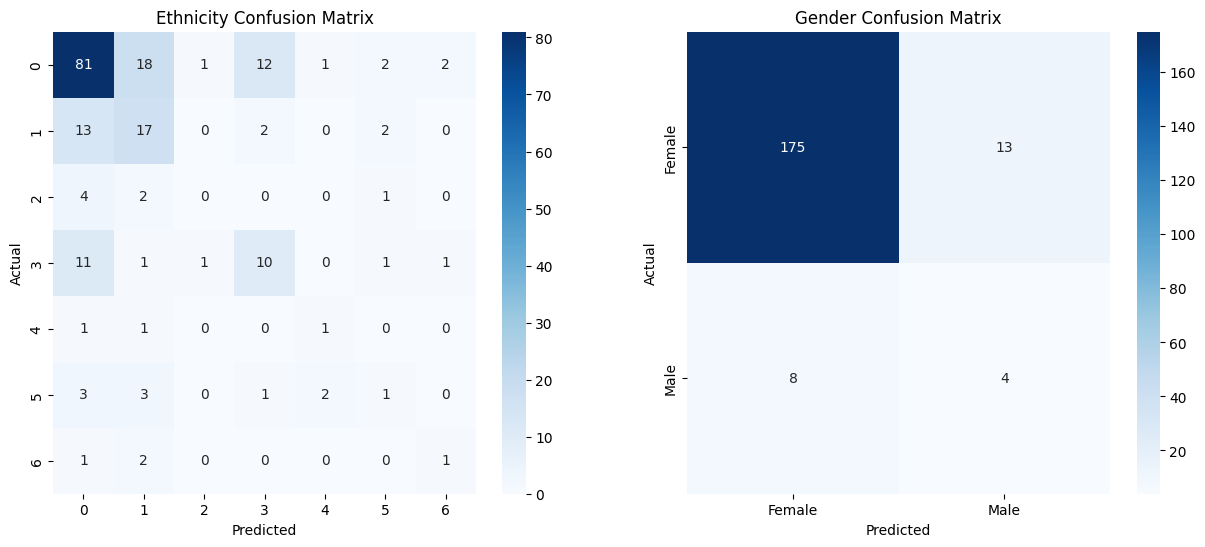

In [37]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
ethnicity_cm = confusion_matrix(Y_ethnicity_test.argmax(axis=1), ethnicity_pred.argmax(axis=1))
sns.heatmap(ethnicity_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(7)], yticklabels=[str(i) for i in range(7)])
plt.title('Ethnicity Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
gender_cm = confusion_matrix(Y_gender_test, (gender_pred > 0.5).astype(int))
sns.heatmap(gender_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Gender Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [38]:
ethnicity_pred, gender_pred = updated_model.predict(X_test)
ethnicity_report = classification_report(Y_ethnicity_test.argmax(axis=1), ethnicity_pred.argmax(axis=1))
gender_report = classification_report(Y_gender_test, (gender_pred > 0.5).astype(int))


print("Ethnicity Classification Report:\n", ethnicity_report)
print("\n\n\n")
print("Gender Classification Report:\n", gender_report)

7/7 [==============================] - 0s 4ms/step
Ethnicity Classification Report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74       117
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         4

    accuracy                           0.58       200
   macro avg       0.08      0.14      0.11       200
weighted avg       0.34      0.58      0.43       200





Gender Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       188
           1       0.00      0.00      0.00        12

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted av

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

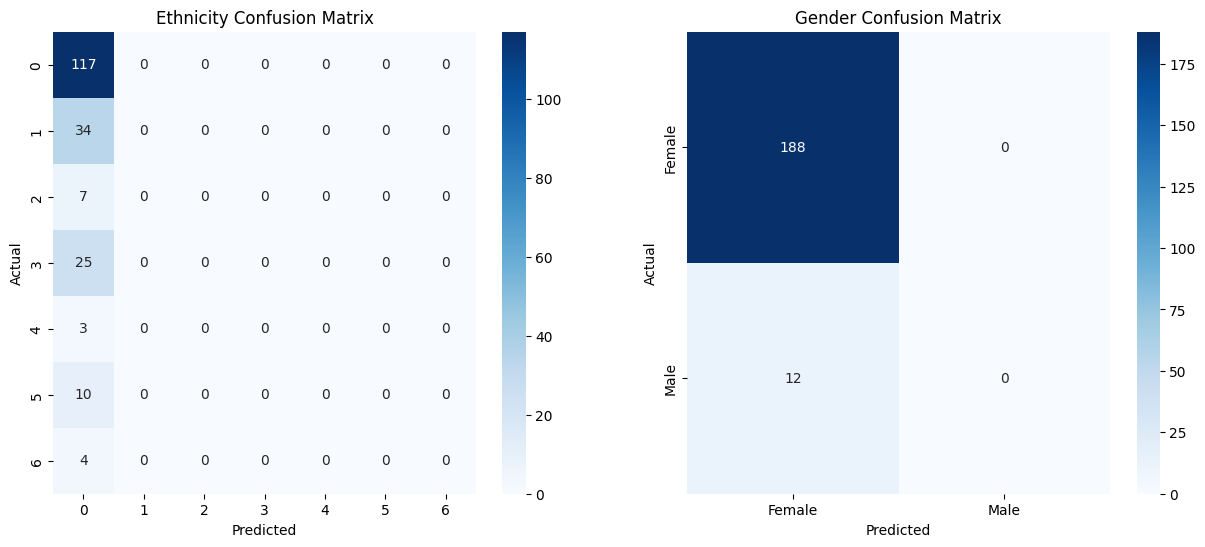

In [39]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
ethnicity_cm = confusion_matrix(Y_ethnicity_test.argmax(axis=1), ethnicity_pred.argmax(axis=1))
sns.heatmap(ethnicity_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(7)], yticklabels=[str(i) for i in range(7)])
plt.title('Ethnicity Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
gender_cm = confusion_matrix(Y_gender_test, (gender_pred > 0.5).astype(int))
sns.heatmap(gender_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Gender Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()